In [1]:
import torch
import torch.nn as nn
import PIL.Image
import io
import numpy as np
import datasets
import torchaudio
import einops
import tempfile
from IPython.display import Audio as play
from torchvision.transforms.v2 import CenterCrop, PILToTensor, ToPILImage, Pad, CenterCrop
from types import SimpleNamespace
from autocodec.codec import AutoCodecND, latent_to_pil, pil_to_latent

In [2]:
device = "cpu"
valid_dataset = dataset = datasets.load_dataset("danjacobellis/musdb_segments",split='validation')

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

In [3]:
checkpoint = torch.load('../hf/dance/LF_stereo_f512c16_v1.0.pth', map_location=device,weights_only=False)
config = checkpoint['config']
model = AutoCodecND(
    dim=1,
    input_channels=config.input_channels,
    J=int(np.log2(config.F)),
    latent_dim=config.latent_dim,
    lightweight_encode=config.lightweight_encode,
    lightweight_decode=config.lightweight_decode,
    post_filter=config.post_filter
).to(device)

model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [4]:
L = 2**19
C = config.input_channels
center_crop = CenterCrop((1, L))
def valid_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, C, L), dtype=torch.float)
    for i_sample, sample in enumerate(batch):
        xi = torch.zeros((C, 1, 2**21), dtype=torch.int16)
        audio_mix, fs = torchaudio.load(sample['audio_mix']['bytes'], normalize=False)
        xi[:, 0, :] = audio_mix
        xi = center_crop(xi).to(torch.float)
        xi = xi.squeeze(1)
        xi = xi - xi.mean()
        max_abs = xi.abs().max()
        xi = xi / (max_abs + 1e-8)
        x[i_sample, :, :] = xi
    return x

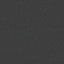

123.33286285579864 compression ratio
64.0× dimension reduction
33.700921554565426 dB PSNR


In [5]:
batch = dataset.select([25])
x = valid_collate_fn(batch).to(device)
model.eval()
with torch.no_grad():
    z = model.encode(x)
    latent = model.quantize.compand(z).round()
    latent_reshaped = einops.rearrange(latent, 'b c (h w) -> b c h w', h=32)
    latent_img = latent_to_pil(latent_reshaped, n_bits=8, C=4)
    display(latent_img[0])
    buff = io.BytesIO()
    latent_img[0].save(buff, format='TIFF', compression='tiff_adobe_deflate')
    tiff_bytes = buff.getbuffer()
    print(f"{x.numel()/len(tiff_bytes)} compression ratio")
    print(f"{x.numel()/z.numel()}× dimension reduction")
    latent_decoded = pil_to_latent([PIL.Image.open(buff)], N=16, n_bits=8, C=4)
    latent_decoded = einops.rearrange(latent_decoded, 'b c h w -> b c (h w)')
    x_hat = model.decode(latent_decoded)
    if config.post_filter:
        x_hat = model.post_filter(x_hat)
    x_hat = x_hat.clamp(-1,1)
mse = torch.nn.functional.mse_loss(x,x_hat)
PSNR = -10*mse.log10().item() + 6.02
print(f"{PSNR} dB PSNR")

In [ ]:
play(x[0].cpu(),rate=44100)

In [ ]:
play(x_hat[0].cpu(),rate=44100)

In [6]:
buff = io.BytesIO()
torchaudio.save(
    uri=buff,
    src=x[0],
    sample_rate=44100,
    format='opus',
    encoding='OPUS',
    compression=torchaudio.io.CodecConfig(bit_rate=6000),
)
opus_bytes = buff.getbuffer()
print(f"{x.numel()/len(opus_bytes)} compression ratio")
with tempfile.NamedTemporaryFile(delete=False, suffix='.opus') as temp_file:
    temp_file.write(opus_bytes)
    temp_file_path = temp_file.name
x_hat, fs2 = torchaudio.load(temp_file_path)
x_hat = torchaudio.transforms.Resample(fs2,44100)(x_hat)
mse1 = torch.nn.functional.mse_loss(x[0],x_hat[:,:-1])
mse2 = torch.nn.functional.mse_loss(x[0],x_hat[:,1:])
PSNR1 = -10*mse1.log10().item() + 6.02
PSNR2 = -10*mse2.log10().item() + 6.02
print(f"{max(PSNR1,PSNR2)} dB PSNR")

122.85600468658465 compression ratio
23.977247495651245 dB PSNR


In [ ]:
play(x_hat[0].cpu(),rate=44100)